In [2]:
import pandas as pd
import numpy as np
import sklearn
import sagemaker
import boto3
import yfinance as yf
import matplotlib.pyplot as plt

from preprocess import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/kishnashenoy/Library/Application Support/sagemaker/config.yaml


2024-08-27 16:41:51.126528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = "stockpredwebbucket"
print("Using bucket " + bucket)

Using bucket stockpredwebbucket


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Initial test and model training before creating a module to preprocess and graph for us

Training a model on Tesla stock

In [6]:
stocks = ['TSLA',
          'MSFT',
          'SPY']

tsla = yf.Ticker(stocks[0])
hist = tsla.history(period='48mo').iloc[:,:5]
hist

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-24 00:00:00-04:00,141.751999,141.933334,128.501328,134.279999,300954000
2020-08-25 00:00:00-04:00,131.659332,135.196671,131.199997,134.889328,159883500
2020-08-26 00:00:00-04:00,137.333328,144.399994,136.908661,143.544662,213591000
2020-08-27 00:00:00-04:00,145.363998,153.039993,142.833328,149.250000,355395000
2020-08-28 00:00:00-04:00,153.007996,154.565994,145.768005,147.559998,301218000
...,...,...,...,...,...
2024-08-19 00:00:00-04:00,217.070007,222.979996,214.089996,222.720001,76435200
2024-08-20 00:00:00-04:00,224.880005,228.220001,219.559998,221.100006,74001200
2024-08-21 00:00:00-04:00,222.669998,224.660004,218.860001,223.270004,70146000


### Calculate EMAs (8-day and 20-day). Tried to use SMAs as well but the model either overfit or was lackluster with its predictions

Since we want to try and estimate/predict a stock price short term (closing price of current day), I decided to use shorter EMA estimations

In [19]:
# Define the span for the EMAs
short_span = 8
long_span = 20

# Calculate the Simple Moving Averages (SMA) for the initial EMA values
hist['SMA_8'] = hist['Close'].rolling(window=short_span).mean()
hist['SMA_20'] = hist['Close'].rolling(window=long_span).mean()

# Calculate the 12-day EMA starting from the 12-day SMA
hist['EMA_8'] = hist['Close'].ewm(span=short_span, adjust=False, min_periods=short_span).mean()

# Calculate the 50-day EMA starting from the 50-day SMA
hist['EMA_20'] = hist['Close'].ewm(span=long_span, adjust=False, min_periods=long_span).mean()

In [20]:
hist = hist[['Open', 'High', 'Low', 'Close', 'SMA_8', 'SMA_20', 'EMA_8', 'EMA_20']]
33
hist.drop(columns=['SMA_8', 'SMA_20'], inplace=True)
hist.dropna(inplace=True)
hist

,Open,High,Low,Close,EMA_8,EMA_20
Date,,,,,,
2020-09-21 00:00:00-04:00,151.043335,151.893326,135.690002,149.796661,142.924378,139.939855
2020-09-22 00:00:00-04:00,143.199997,145.919998,139.199997,141.410004,142.587850,140.079870
2020-09-23 00:00:00-04:00,135.053329,137.383331,125.293335,126.786667,139.076476,138.813850
2020-09-24 00:00:00-04:00,121.266670,133.166672,117.099998,129.263336,136.895778,137.904277
2020-09-25 00:00:00-04:00,131.156662,136.243332,130.433334,135.779999,136.647827,137.701965
...,...,...,...,...,...,...
2024-08-19 00:00:00-04:00,217.070007,222.979996,214.089996,222.720001,211.517706,213.716550
2024-08-20 00:00:00-04:00,224.880005,228.220001,219.559998,221.100006,213.647106,214.419736
2024-08-21 00:00:00-04:00,222.669998,224.660004,218.860001,223.270004,215.785528,215.262619


### StandardScaling the features and preparing them for a train/test split. Also keeping track of the dates being used for graphical analysis later on

In [21]:
features = ['Open', 'High', 'Low', 'Close', 'EMA_8', 'EMA_20']

# Scale the selected features
scaler = StandardScaler()
scaled = scaler.fit_transform(hist[features].values)  # Scale all relevant features

pred_days = 30
train_split = 0.8

# Prepare the date index (for tracking predictions)
date_index = hist[pred_days:].index

x_train = []
y_train = []

# Create sequences of the past pred_days for training
for x in range(pred_days, len(scaled)):
    x_train.append(scaled[x-pred_days:x])  # Include all features in the sequence
    y_train.append(scaled[x, 3])  # Predict the closing price (index 3 corresponds to 'Close')

# # Convert to numpy arrays for training
x_train, y_train = np.array(x_train), np.array(y_train)

# Split the data into training and testing sets
split_idx = int(np.ceil(len(x_train) * train_split))
x_train, x_test = x_train[:split_idx], x_train[split_idx:]
y_train, y_test = y_train[:split_idx], y_train[split_idx:]

# Reshape the data to fit the model's input requirements
# The shape will be (number of samples, number of time steps, number of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

# Optional: Separate the date index for the training and testing sets
x_train_date, x_test_date = np.array(date_index[:split_idx]), np.array(date_index[split_idx:])

### Actually training the model. I tinkered with the hyperparams (specifically epochs and batch size), and parameters for each layers aiming for a good fit. Began to include validation loss in the model training as well

The reason for the inclusion of the validation loss was to graph the validation loss vs the test loss to check for diversion, which indicates overfitting (when the validation loss begins to increase and diverge from the training loss after a certain epoch). Usually this is done with test loss but I'm fairly certain using a validation set should be ok too.

In [22]:
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], 6)))
model.add(Dropout(0.1))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=60))
model.add(Dense(units=1))

model.compile(optimizer='Adam', loss='mse')
history = model.fit(x_train, y_train, epochs=80, batch_size=16, validation_split=0.1)

Epoch 1/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.5381 - val_loss: 0.1579
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1370 - val_loss: 0.0960
Epoch 3/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1173 - val_loss: 0.0825
Epoch 4/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0977 - val_loss: 0.0724
Epoch 5/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0952 - val_loss: 0.0544
Epoch 6/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0701 - val_loss: 0.0579
Epoch 7/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0589 - val_loss: 0.0485
Epoch 8/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0568 - val_loss: 0.0445
Epoch 9/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0649 - val_loss: 0.0432
Epoch 10/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0595 - val_loss: 0.0455
Epoch 11/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0606 - val_loss: 0.0393
Epoch 12/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

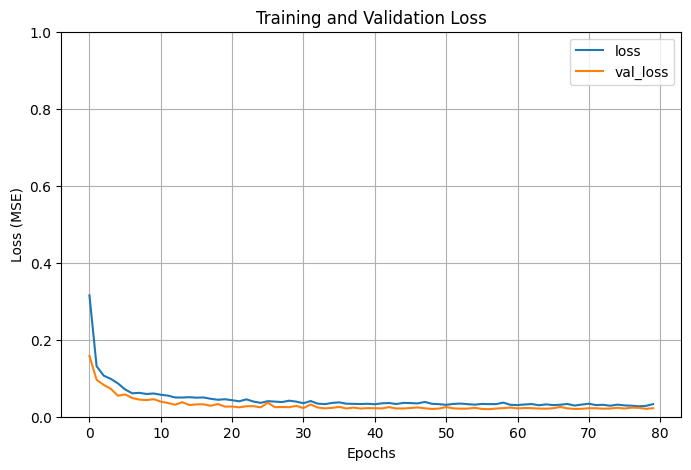

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # Adjust the vertical axis to be the same scale for better comparison
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show()

### Un-standardize, or inverse transform the predicted close prices and the actual close prices in order to compare their graphs

In [23]:
y_t = y_test.reshape(-1,1)

# Inverse transform only the Close feature
scaler_close = StandardScaler()
scaler_close.mean_ = scaler.mean_[3]  # Mean of the 'Close' feature
scaler_close.scale_ = scaler.scale_[3]  # Scale of the 'Close' feature

# Apply inverse_transform to get the actual and predicted Close prices
y_actual = scaler_close.inverse_transform(y_t)
y_pred = scaler_close.inverse_transform(model.predict(x_test))#.reshape(-1, 1))

# y_actual = scaler.inverse_transform(y_t)
# y_pred = scaler.inverse_transform(model.predict(x_test))
new_data = np.array([x.date() for x in x_test_date])

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


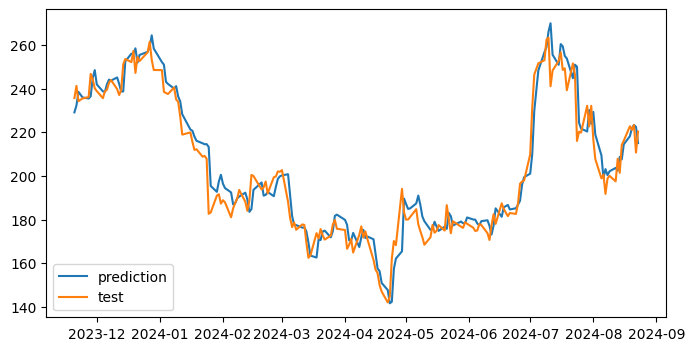

In [25]:
plt.figure(figsize=(8,4))

plt.plot(new_data, y_pred, label = 'prediction')
plt.plot(new_data, y_actual, label = 'test')
plt.legend()
plt.show()

Checking that when I inverse transform the features, they invert back to their original values

In [26]:
scaled_features = StandardScaler()
scaled_features.mean_ = scaler.mean_[:6]  # Mean of the first 3 features
scaled_features.scale_ = scaler.scale_[:6]  # Scale of the first 3 features

scaled_features.inverse_transform(x_test[-1])

array([[235.80000305, 251.83999634, 233.08999634, 248.22999573,
        243.1820118 , 221.86019488],
       [255.97000122, 265.6000061 , 251.72999573, 252.63999939,
        245.28378682, 224.79160484],
       [255.30999756, 258.61999512, 245.80000305, 256.55999756,
        247.78961143, 227.81716605],
       [252.72999573, 258.47000122, 246.17999268, 248.5       ,
        247.94747555, 229.78695976],
       [251.08999634, 257.14001465, 247.19999695, 249.22999573,
        248.23248004, 231.63867747],
       [247.78999329, 249.44000244, 236.83000183, 239.19999695,
        246.22526157, 232.35880313],
       [244.21000671, 253.21000671, 243.75      , 251.50999451,
        247.39964667, 234.18272612],
       [253.6000061 , 255.75999451, 245.63000488, 246.38000488,
        247.17305961, 235.34437172],
       [225.41999817, 225.99000549, 214.71000671, 215.99000549,
        240.24349203, 233.50109874],
       [216.80000305, 226.        , 216.22999573, 220.25      ,
        235.8004938 , 232.2

### Using the most recent 30-day period to predict the closing price for today to ensure that this functionality is possibility.

In [27]:
real_data = x_test[-1]
# real_data = np.array(real_data)
real_data = np.reshape(real_data, (1, real_data.shape[0], real_data.shape[1]))

prediction = model.predict(real_data)
prediction = scaler_close.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: [[215.01312]]


In [28]:
rmse = mean_squared_error(y_actual, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_actual, y_pred)
print("RSME: ", rmse)
print ("MAPE: ", mape)

RSME:  7.913141388160772
MAPE:  0.02907509443477964


In [12]:
import pickle

model_pkl_file = "tsla_lstm.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

NameError: name 'model' is not defined

## Using the module preprocessing.py to ensure that the same pipeline above can be replicated by using the functions in the module.

In [7]:
pre = preprocess('msft')

                                 Open        High         Low       Close  \
Date                                                                        
2020-09-25 00:00:00-04:00  196.634138  201.937599  195.658445  200.759064   
2020-09-28 00:00:00-04:00  203.715097  205.347679  200.990903  202.324020   
2020-09-29 00:00:00-04:00  202.237110  202.932649  199.783401  200.218109   
2020-09-30 00:00:00-04:00  200.672109  204.777710  199.522539  203.183777   
2020-10-01 00:00:00-04:00  206.236443  206.719455  204.140173  205.241440   
...                               ...         ...         ...         ...   
2024-08-21 00:00:00-04:00  424.079987  426.399994  421.720001  424.140015   
2024-08-22 00:00:00-04:00  424.359985  426.790009  414.609985  415.549988   
2024-08-23 00:00:00-04:00  416.980011  419.260010  412.089996  416.790009   
2024-08-26 00:00:00-04:00  416.369995  417.279999  411.339996  413.489990   
2024-08-27 00:00:00-04:00  413.000000  414.359985  410.250000  413.839996   

/Users/kishnashenoy/Desktop/Projects/datasci/stockpred_website/lib/python3.10/site-packages/yfinance/base.py:303: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Dividends"].fillna(0, inplace=True)
/Users/kishnashenoy/Desktop/Projects/datasci/stockpred_website/lib/python3.10/site-packages/yfinance/base.py:304: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the 

In [14]:
import pickle

In [15]:
mdl=pickle.load(open('tsla_lstm.pkl','rb'))

EOFError: Ran out of input

In [16]:
mdl

<Sequential name=sequential_1, built=True>

In [4]:
model2 = Sequential()
model2.add(LSTM(units=60, return_sequences=True, input_shape=(pre['x_train'].shape[1], 6)))
model2.add(Dropout(0.1))
model2.add(LSTM(units=60, return_sequences=True))
model2.add(Dropout(0.1))
model2.add(LSTM(units=60))
model2.add(Dense(units=1))

model2.compile(optimizer='Adam', loss='mse')
history = model2.fit(pre['x_train'], pre['y_train'], epochs=80, batch_size=16, validation_split=0.1)

Epoch 1/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.5261 - val_loss: 0.1559
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1519 - val_loss: 0.0910
Epoch 3/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0979 - val_loss: 0.0825
Epoch 4/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0797 - val_loss: 0.0591
Epoch 5/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0814 - val_loss: 0.0555
Epoch 6/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0640 - val_loss: 0.0434
Epoch 7/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0674 - val_loss: 0.0428
Epoch 8/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0671 - val_loss: 0.0420
Epoch 9/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0608 - val_loss: 0.0427
Epoch 10/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0575 - val_loss: 0.0334
Epoch 11/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0523 - val_loss: 0.0354
Epoch 12/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


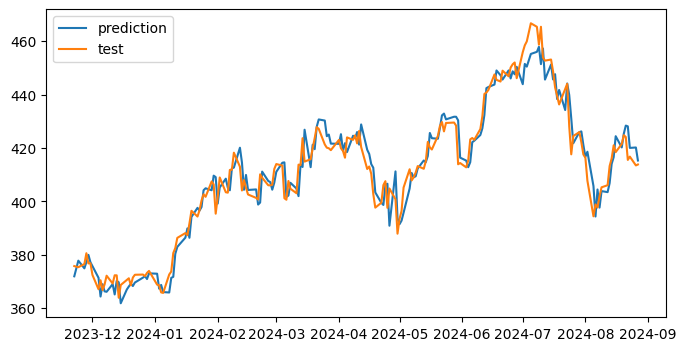

In [8]:
graph = graph_data(pre['scaler'], pre['x_test'], pre['y_test'], pre['x_test_date'], mdl)

plt.figure(figsize=(8,4))

plt.plot(graph['new_data'], graph['y_pred'], label = 'prediction')
plt.plot(graph['new_data'], graph['y_actual'], label = 'test')
plt.legend()
plt.show()

In [9]:
prediction(pre['x_test'][-1], graph['scaler_close'], mdl)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([415.331], dtype=float32)

In [10]:
rmse2 = mean_squared_error(graph['y_actual'], graph['y_pred'], squared=False)
mape2 = mean_absolute_percentage_error(graph['y_actual'], graph['y_pred'])
print("RSME: ", rmse2)
print ("MAPE: ", mape2)

RSME:  5.5151276729893235
MAPE:  0.010425814318277922


/Users/kishnashenoy/Desktop/Projects/datasci/stockpred_website/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
